# TP2 Laboratorio de Datos - 1C 2022

### Julian villa - LU 429/12

# Los datos

Link a los datos: https://drive.google.com/drive/folders/18g4IG96CGvHsWSeLGQJ5gPtFGDpZkdGx?usp=sharing

Los datos corresponden a registros de accidentes de tránsito en EEUU entre 2016 y 2021.

Las primeras dos columnas ("unnamed") no sirve nara nada y se pueden descartar. 

La columna 'Severity' contiene la severidad del accidente (0 significa baja, 1 significa alta)

Luego tenemos la hora de comienzo y final del accidente, la latitud/longitud inicial y final del accidente (entre que valores queda delimitado), la distancia de camino afectada por el accidente, una descripción verbal hecha por un humano, número y nombre de la calle donde ocurrió, lado de la calle (izquierda o derecha), ciudad, condado, estado, código postal, huso horario, código de aeropuerto donde se encuentra la estación meterológica más cercana al accidente, hora en la cual se midió el clima,temperatura, temperatura del viento, humedad, presión, visibilidad, dirección del viento, condición climática (despejado, sol, nieve, etc), presencia de comodidades ("amenities") en la cercanía del accidente, presencia de loma de burro, presencia de un cruce, presencia de señal de ceder paso, presencia de unión de calles, presencia de cartel de no salida, presencia de vías de tren, presencia de rotonda, presencia de estación, presencia de signo de parar, presencia de moderadores de tráfico, presencia de señales de tránsito, presencia de calle en forma de U ("loop"), día u oscuridad de acuerdo a la salida del sol, día u oscuridad de acuerdo a la penumbra civil (si es o no necesario utilizar alumbramiento eléctrico), día u oscuridad de acuerdo a la penumbra náutica, día u oscuridad de acuerdo a la penumbra astronómica.

No todos estos campos son necesariamente útiles, y tampoco no todos están en un formato numérico directamente utilizable (por ejemplo, hay strings en la parte de descripción del accidente). Es parte del trabajo decidir que features quedarse, que features sumar, y como extraer información relevante de los features más complejos. 

In [ ]:
from google.colab import drive
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.metrics import roc_auc_score

drive.mount('/content/drive') # montamos el drive

# cargamos el dataframe de entrenamiento y el dataframe de testeo
# el dataframe de entrenamiento tiene toda la información, incluyendo la columna 'Severity' (severidad)
# esta es la columna que vamos a entrenar el modelo para predecir: 0=severidad baja; 1=severidad alta.
# en cambio, el dataframe de test no tiene esta columna: son los datos que usamos para generar la predicción que se entrega 
filename_train = '/content/drive/My Drive/LaboDatos_1C2022/LaboDatos2022/SegundaEjercitacion/train.csv' 
#filename_test = '/content/drive/My Drive/LaboDatos_1C2022/LaboDatos2022/SegundaEjercitacion/test4alumnxs.csv' 
filename_test = '/content/drive/My Drive/LaboDatos_1C2022/test.csv'

df_train = pd.read_csv(filename_train)
df_test = pd.read_csv(filename_test)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Exploración de los datos

Veamos qué features contiene el dataset, la relación entre los mismos y si tiene datos faltantes. 

Comenzamos visualizando el dataset.

In [ ]:
# Retiramos las primeras dos columnas que no sirven -lo aclara en
#la consigna-.
df_train.drop(['Unnamed: 0', 'Unnamed: 0.1'], inplace=True, axis=1)
df_test.drop(['Unnamed: 0', 'Unnamed: 0.1'], inplace=True, axis=1)

# Vemos que columnas tiene y la forma
print(df_train.columns)
print(f'El tamaño del conjunto de entrenamiento es: {df_train.shape}')

Index(['Severity', 'Start_Time', 'End_Time', 'Start_Lat', 'Start_Lng',
       'End_Lat', 'End_Lng', 'Distance(mi)', 'Description', 'Number', 'Street',
       'Side', 'City', 'County', 'State', 'Zipcode', 'Country', 'Timezone',
       'Airport_Code', 'Weather_Timestamp', 'Temperature(F)', 'Wind_Chill(F)',
       'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Direction',
       'Wind_Speed(mph)', 'Precipitation(in)', 'Weather_Condition', 'Amenity',
       'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway',
       'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal',
       'Turning_Loop', 'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight',
       'Astronomical_Twilight'],
      dtype='object')
El tamaño del conjunto de entrenamiento es: (45834, 46)


In [ ]:
# Veamos que pinta tiene el dataset
df_train.head()

,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Description,Number,...,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,0,2021-08-19 23:58:30.000000000,2021-08-20 00:36:30.000000000,35.879641,-78.734582,35.884381,-78.740822,0.479,Stationary traffic on US-70 W from Lynn Rd (US...,8396.0,...,False,False,False,False,False,False,Night,Night,Night,Night
1,0,2021-01-28 21:09:00.000000000,2021-01-29 01:18:47.000000000,36.206389,-121.116768,36.206635,-121.116980,0.021,52500 LONOAK RD. CA TOW ADVISED ETA 30MIN DRIV...,722.0,...,False,False,False,False,False,False,Night,Night,Night,Night
2,0,2021-02-12 04:48:00,2021-02-12 06:26:21,30.499754,-91.138325,30.499795,-91.136996,0.079,Incident on HOLLYWOOD ST near WINCHESTER AVE D...,5224.0,...,False,False,False,False,False,False,Night,Night,Night,Night
3,0,2020-12-09 13:25:30,2020-12-10 00:19:49,26.548679,-81.871670,26.546193,-81.871104,0.175,Stationary traffic on FL-45 - County Hwy-876 -...,13338.0,...,False,False,False,False,False,False,Day,Day,Day,Day
4,0,2020-10-30 16:30:18,2020-10-30 17:45:26,45.533651,-94.100321,45.532940,-94.099488,0.064,Incident on US-10 EB near MN-301 Drive with ca...,2450.0,...,False,False,False,False,False,False,Day,Day,Day,Day


Chequeamos si tiene duplicados o datos faltantes.

In [ ]:
# Veamos si tiene duplicados y los borramos
df_train.drop_duplicates()
print(f'La nueva forma de los datos es: {df_train.shape}')

La nueva forma de los datos es: (45834, 46)


In [ ]:
# Hagamos lo mismo con los NaN
df_train.isnull().any()

Severity                 False
Start_Time               False
End_Time                 False
Start_Lat                False
Start_Lng                False
End_Lat                  False
End_Lng                  False
Distance(mi)             False
Description              False
Number                   False
Street                   False
Side                     False
City                     False
County                   False
State                    False
Zipcode                  False
Country                  False
Timezone                 False
Airport_Code             False
Weather_Timestamp        False
Temperature(F)           False
Wind_Chill(F)            False
Humidity(%)              False
Pressure(in)             False
Visibility(mi)           False
Wind_Direction           False
Wind_Speed(mph)          False
Precipitation(in)        False
Weather_Condition        False
Amenity                  False
Bump                     False
Crossing                 False
Give_Way

In [ ]:
df_train['Severity'].value_counts()

0    28072
1    17762
Name: Severity, dtype: int64

Sin duplicados ni datos faltantes, analicemos la relación entre los features, y veamos qué información podemos sacar de cada uno.

In [ ]:
df_train.describe()

,Severity,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Number,Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Speed(mph),Precipitation(in)
count,45834.000000,45834.000000,45834.000000,45834.000000,45834.000000,45834.000000,4.583400e+04,45834.000000,45834.000000,45834.000000,45834.000000,45834.000000,45834.000000,45834.000000
mean,0.387529,36.386877,-92.562335,36.387211,-92.561521,0.512628,8.034231e+03,61.674329,60.493446,65.574923,29.356889,9.116319,7.108474,0.004861
std,0.487191,5.649315,17.554622,5.649368,17.553586,1.881017,4.894952e+04,18.632667,20.576023,22.493000,1.133045,2.624345,5.376711,0.075165
min,0.000000,24.574762,-124.479176,24.574505,-124.483021,0.000000,1.000000e+00,-27.000000,-36.000000,2.000000,19.240000,0.000000,0.000000,0.000000
25%,0.000000,33.168826,-112.107406,33.171855,-112.108263,0.055000,1.060000e+03,48.000000,47.000000,50.000000,29.210000,10.000000,3.000000,0.000000
50%,0.000000,36.836409,-82.797545,36.837399,-82.797392,0.147000,3.663000e+03,64.000000,64.000000,68.000000,29.720000,10.000000,7.000000,0.000000
75%,1.000000,40.464720,-79.323464,40.465333,-79.325385,0.414000,9.143750e+03,76.000000,76.000000,85.000000,29.960000,10.000000,10.000000,0.000000
max,1.000000,48.996539,-68.618050,48.997091,-68.616840,112.968000,9.999997e+06,111.000000,111.000000,100.000000,58.130000,100.000000,53.000000,9.990000


In [ ]:
df_train.describe(include=[object])

,Start_Time,End_Time,Description,Street,Side,City,County,State,Zipcode,Country,Timezone,Airport_Code,Weather_Timestamp,Wind_Direction,Weather_Condition,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
count,45834,45834,45834,45834,45834,45834,45834,45834,45834,45834,45834,45834,45834,45834,45834,45834,45834,45834,45834
unique,42750,43562,39677,19884,2,5606,1167,49,33669,1,4,1443,31726,23,60,2,2,2,2
top,2021-11-21 18:37:51,2021-11-22 08:00:00,A crash has occurred causing no to minimum del...,Main St,R,Miami,Miami-Dade,FL,33186,US,US/Eastern,KORL,2021-11-21 18:45:00,CALM,Fair,Day,Day,Day,Day
freq,47,48,119,170,25567,2194,3057,7735,112,45834,25819,925,62,8494,21874,28263,30081,32107,33952


### Limpieza de datos categóricos

Comencemos desechando algunas columnas que de antemano puedo inferir que no me van a servir.

In [ ]:
# La columna 'Country' es irrelevante: 1 solo valor (US)
df_train.drop(['Country'], axis=1, inplace=True)
df_test.drop(['Country'], axis=1, inplace=True)

# Airport_Code es muy complicada para codificar, y a priori no debería influir demasiado
df_train.drop(['Airport_Code'], axis=1, inplace=True)
df_test.drop(['Airport_Code'], axis=1, inplace=True)


En vez de tener la hora en la que se midieron las condiciones climaticas, agrego la diferencia entre el horario del accidente y la misma, en minutos. 
Esta información me da una idea de qué tan confiables son las condiciones meteorológicas declaradas. 

Podemos hacer lo mismo con Start_time y End_time y así tener una noción de la duración del incidente, además de que obtenermos datos numéricos con los que podemos entrenar.

In [ ]:
import datetime

# Pasamos de str a datetime.datetime
df_train['Start_Time'] = pd.to_datetime(df_train['Start_Time'], infer_datetime_format=True)
df_train['End_Time'] = pd.to_datetime(df_train['End_Time'], infer_datetime_format=True)
df_train['Weather_Timestamp'] = pd.to_datetime(df_train['Weather_Timestamp'], infer_datetime_format=True)

# Agregamos la columna con la diferencia en minutos 
df_train['Weather_Delay(min)'] = df_train['Start_Time'] - df_train['Weather_Timestamp']
df_train['Weather_Delay(min)'] = df_train['Weather_Delay(min)'].apply(lambda x: x.total_seconds()/60) 

# Agregamos la columna con la diferencia en minutos 
df_train['Delta_Time(min)'] = df_train['End_Time'] - df_train['Start_Time']
df_train['Delta_Time(min)'] = df_train['Delta_Time(min)'].apply(lambda x: x.total_seconds()/60) 

# Tiramos Weather_Timestamp
df_train.drop(['Weather_Timestamp', 'Start_Time', 'End_Time'], axis=1, inplace=True)

# Deberiamos tener un total de 43 columnas
print(df_train.shape)

# Hacemos lo mismo para el Test
df_test['Start_Time'] = pd.to_datetime(df_test['Start_Time'], infer_datetime_format=True)
df_test['End_Time'] = pd.to_datetime(df_test['End_Time'], infer_datetime_format=True)
df_test['Weather_Timestamp'] = pd.to_datetime(df_test['Weather_Timestamp'], infer_datetime_format=True)

# Agregamos la columna con la diferencia en minutos 
df_test['Weather_Delay(min)'] = df_test['Start_Time'] - df_test['Weather_Timestamp']
df_test['Weather_Delay(min)'] = df_test['Weather_Delay(min)'].apply(lambda x: x.total_seconds()/60) 

# Agregamos la columna con la diferencia en minutos 
df_test['Delta_Time(min)'] = df_test['End_Time'] - df_test['Start_Time']
df_test['Delta_Time(min)'] = df_test['Delta_Time(min)'].apply(lambda x: x.total_seconds()/60) 

# Tiramos Weather_Timestamp
df_test.drop(['Weather_Timestamp', 'Start_Time', 'End_Time'], axis=1, inplace=True)

# Deberiamos tener un total de 42 columnas
print(df_test.shape)

(45834, 43)
(11372, 43)


Vamos a tirar la calle y el número. Además tiramos el condado, la ciudad y el estado. Para ubicar la zona del accidente vamos a dejar el código postal.

In [ ]:
# Conjunto de entrenamiento
df_train.drop(['Number'], axis=1, inplace=True)
df_train.drop(['Street'], axis=1, inplace=True)
df_train.drop(['County'], axis=1, inplace=True)
df_train.drop(['City'], axis=1, inplace=True)
df_train.drop(['State'], axis=1, inplace=True)

# Lo mismo en el conjunto de testeo
df_test.drop(['Number'], axis=1, inplace=True)
df_test.drop(['Street'], axis=1, inplace=True)
df_test.drop(['County'], axis=1, inplace=True)
df_test.drop(['City'], axis=1, inplace=True)
df_test.drop(['State'], axis=1, inplace=True)

El huso horario no nos da información que no tengamos por la ubicación del accidente o por las columnas que me indican si es de día o de noche, así que lo descartamos. Además, de estas últimas tenemos tres: veamos con cuál quedarnos.

In [ ]:
# Tiramos la info del huso horario
df_train.drop(['Timezone'], axis=1, inplace=True)
df_test.drop(['Timezone'], axis=1, inplace=True)

Podemos ver que las variables "Sunrise_Sunset", "Civil_Twilight", "Nautical_Twilight" y "Astronomical_Twilight" son variables categóricas que tenemos que desglosar. Para comenzar podriamos mirar si todas coinciden entre sí, en ese caso podemos quedarnos con una sola y usar _one hot encoder_ para separar en dos columnas que contengan las clases.

In [ ]:
bool_1 = df_train['Civil_Twilight'] == df_train['Nautical_Twilight']
bool_2 = df_train['Nautical_Twilight'] == df_train['Astronomical_Twilight']
bool_3 = df_train['Astronomical_Twilight'] == df_train['Sunrise_Sunset']

df_train[~np.logical_and.reduce((bool_1, bool_2, bool_3))].shape

(5792, 37)

Vemos que existen casos para los que las 4  variables no coinciden. Si bien no se puede condensar la informacion de todas en una sola, vamos a elegir la que nos parezca que informe más. La penumbra astronómica comienza 1 hora y meda antes que el atardecer (Sunrise_Sunset). La civil y naútica comienzan media y una hora antes del atardecer, respectivamente. Nos vamos a quedar con la astronómica, porque sobreestima los horarios en los que la vision está reducida.

In [ ]:
df_train.drop(['Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight'], axis=1, inplace=True)
df_test.drop(['Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight'], axis=1, inplace=True)

Veamos si las etiquetas de Weather_Condition están correlacionadas con el target. Hagamos un un barplot y vemamos si se conserva el ratio entre 0 y 1 al cambiar de etiqueta en Weather_Condition.

In [ ]:
df_train['Weather_Condition'].apply(str.strip)

0        Light Rain with Thunder
1                     Light Rain
2                     Light Rain
3                           Fair
4                           Fair
                  ...           
45829               Fair / Windy
45830                 Light Snow
45831             Cloudy / Windy
45832              Mostly Cloudy
45833                       Fair
Name: Weather_Condition, Length: 45834, dtype: object

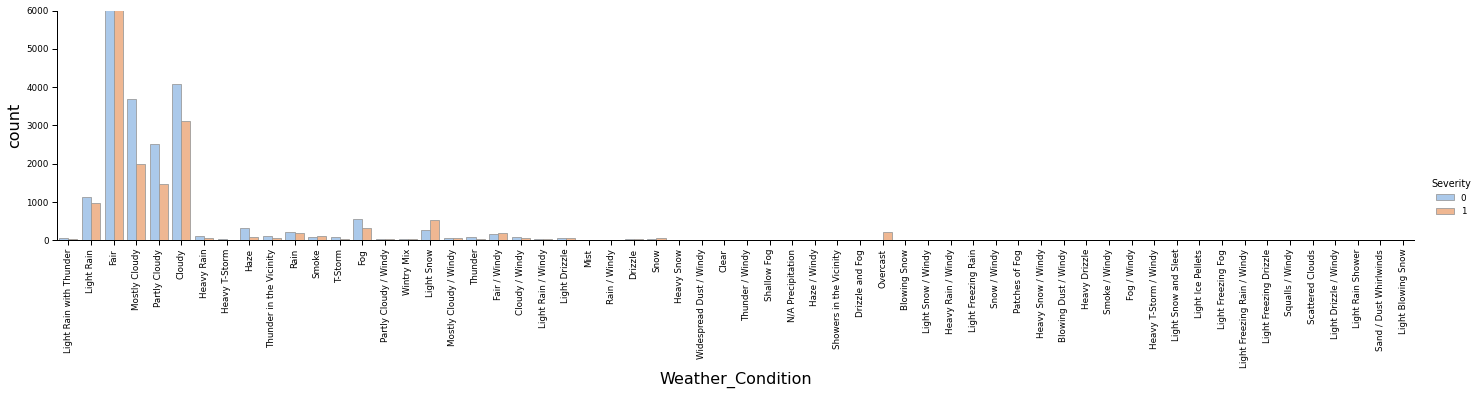

In [ ]:
import seaborn as sns
from matplotlib import pyplot as plt
g = sns.catplot(x="Weather_Condition", hue="Severity", kind="count",
            palette="pastel", edgecolor=".6",
            data=df_train, height=4, aspect=5)
g.set_xticklabels(rotation=90)
g.set(ylim=(0, 6000))

A simple vista no parece haber correlaciones claras, por lo menos para los features que más vuenta se llevan. Podríamos calcular el cociente de cuentas  ver si se mantiene relativamente constante.

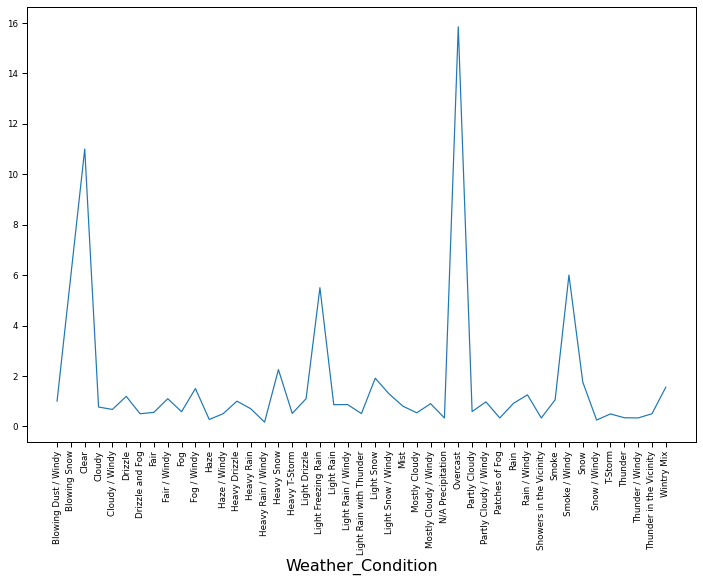

In [ ]:
q = df_train.groupby('Severity')['Weather_Condition'].value_counts().unstack()

ratio = q.loc[1, :]/q.loc[0, :]
ratio.dropna(inplace=True)
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
sns.lineplot(x=ratio.index, y=ratio.values, ax=ax)
plt.xticks(rotation=90)
plt.show()

Como vemos, el ratio se mantiene relativamente constante, salvo en algunos features que no son muy representativos al total de los casos. Así que removemos esta columna también.

In [ ]:
df_train.drop(['Weather_Condition'], axis=1, inplace=True)
df_test.drop(['Weather_Condition'], axis=1, inplace=True)

Podemos ver lo mismo en el caso de Wind_Direction y de Side. En este caso el ratio constante salta a simple vista en el barplot.

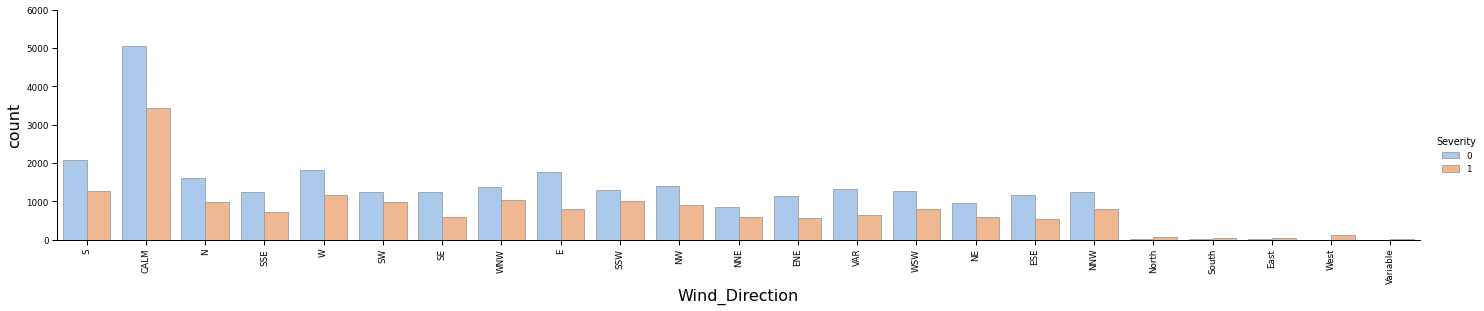

In [ ]:
g = sns.catplot(x="Wind_Direction", hue="Severity", kind="count",
            palette="pastel", edgecolor=".6",
            data=df_train, height=4, aspect=5)
g.set_xticklabels(rotation=90)
g.set(ylim=(0, 6000))

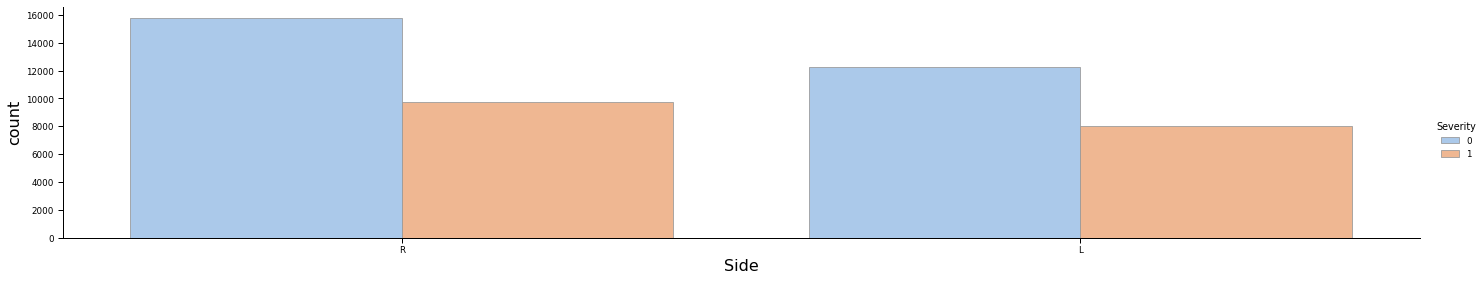

In [ ]:
g = sns.catplot(x="Side", hue="Severity", kind="count",
            palette="pastel", edgecolor=".6",
            data=df_train, height=4, aspect=5)

In [ ]:
df_train.drop(['Wind_Direction'], axis=1, inplace=True)
df_test.drop(['Wind_Direction'], axis=1, inplace=True)

In [ ]:
df_train.drop(['Side'], axis=1, inplace=True)
df_test.drop(['Side'], axis=1, inplace=True)

### Datos de señalización

Veamos si podemos encontrar correlación entre el target y el resto de los datos categóricos, que corresponden a datos de señalización.

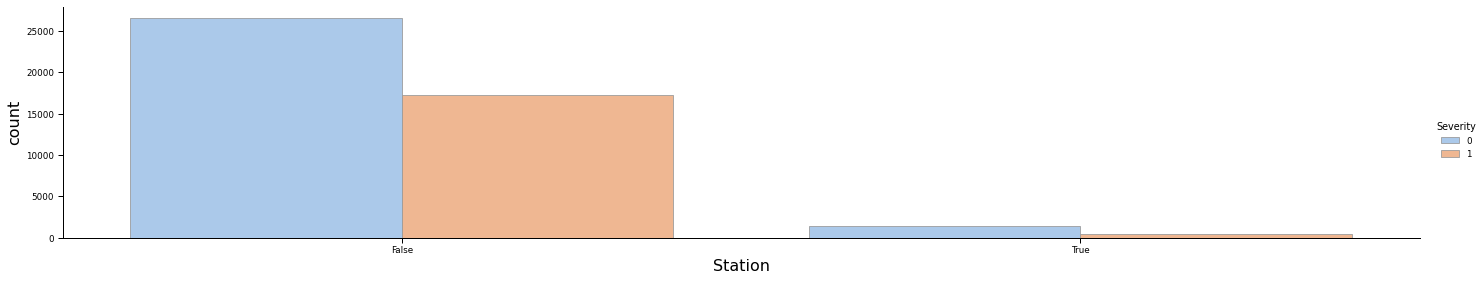

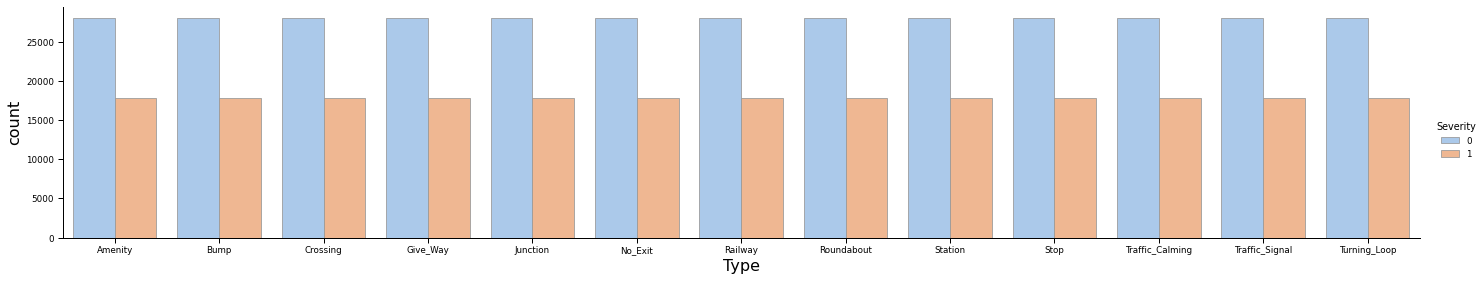

In [ ]:

signal_cols = ['Amenity' ,'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 
           'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 
           'Traffic_Signal', 'Turning_Loop']           

signals_df = df_train.loc[:, ['Severity'] + signal_cols]

signals_df = signals_df.melt(id_vars='Severity', value_vars=signal_cols, 
                 value_name='Signals', var_name='Type')

g = sns.catplot(x="Station", hue="Severity", kind="count",
            palette="pastel", edgecolor=".6",
            data=df_train, height=4, aspect=5)

f = sns.catplot(x="Type", hue="Severity", kind="count",
            palette="pastel", edgecolor=".6",
            data=signals_df, height=4, aspect=5)


Vemos que todas mantienen un ratio constante en Severidad, en la inmensa mayoria los valores son falsos (no hay señalización) y cuando la hay no cambia el ratio entre severidad. Con esto pasamos a eliminarlas del dataset. Chequeamos que luego de esto el dataset tenga 19 columnas

In [ ]:
df_train.drop(signal_cols, axis=1, inplace=True)
df_test.drop(signal_cols, axis=1, inplace=True)
print(df_train.shape)
df_test.shape

(45834, 18)


(11372, 18)

## Limpieza de datos Numéricos

Hago un Pair Plot con las variables numéricas para explorar cuáles separan las clases. 

In [ ]:
# Me quedo con las variables numéricas
df_numeric = df_train.select_dtypes(include=['int64', 'float64'])

# Veamos las distribuciones y correlaciones en un mismo grafico
#sns.pairplot(df_numeric, hue='Severity', diag_kind='kde')

Vemos que no hay combinaciones de dos variables que separen mucho las clases. Otra cosa que vemos es que algunas variables están muy correlacionadas entre sí. Eso hace que tengamos variables superfluas. Veamoslo en un gráfico de correlación.

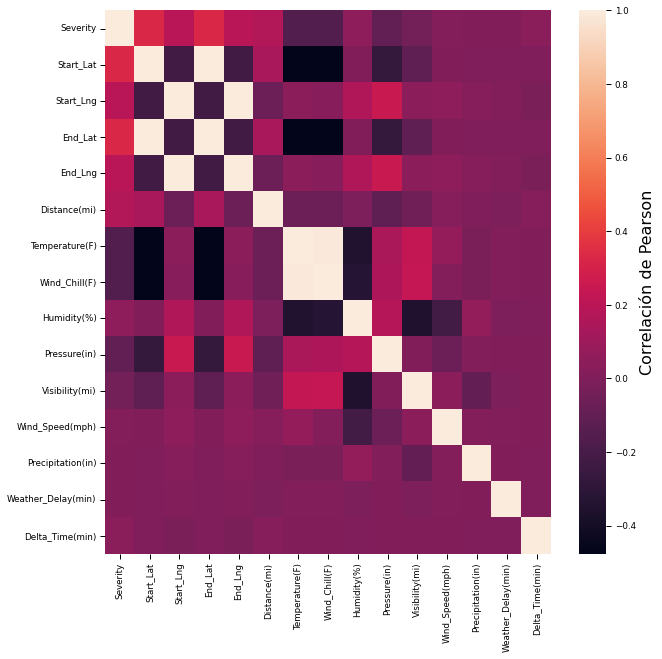

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
sns.heatmap(df_numeric.corr(), cbar_kws={'label': 'Correlación de Pearson'})

Vemos una correlación muy fuerte entre las latitudes y longitudes de comienzo y final del accidente. Estas últimas se resuelven fácil: podemos dejar las de comienzo y la amplitud del accidente nos la da Distance(mi). 

Además "Wind Chill" y "Temperature" también 
están altamente correlacionadas.Veamos las densidades estimadas junto con sus respectivos scatterplots.

In [ ]:
df_train.drop(['End_Lat', 'End_Lng'], axis=1, inplace=True)
df_test.drop(['End_Lat', 'End_Lng'], axis=1, inplace=True)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1213: UserWarning: The following kwargs were not used by contour: 'lw'
  **contour_kws,


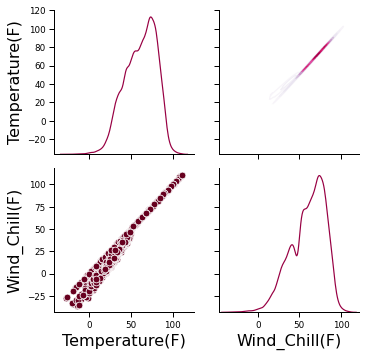

In [ ]:
# Aislamos las variables colineales
df_linear = df_train[["Temperature(F)", "Wind_Chill(F)"]]

sns.set_context("paper", rc={"axes.labelsize":16})
g = sns.PairGrid(df_linear)
g.map_diag(sns.kdeplot, color = '#980043')
g.map_upper(sns.kdeplot, cmap = 'PuRd', lw=2)
g.map_lower(plt.scatter, color = '#67001f', edgecolor="w", s=46)
g.add_legend()

Esta colinealidad nos indica que una de las dos variables va a ser redundante a la hora de clasificar. Podríamos dejar de la variable "Temperature" y tirar "Wind Chill".

In [ ]:
df_train.drop(['Wind_Chill(F)'], axis=1, inplace=True)
df_test.drop(['Wind_Chill(F)'], axis=1, inplace=True)

Con esto nuesto DataFrame nos debería quedar de 15 columnas.

In [ ]:
print(df_train.shape)
df_test.shape

(45834, 15)


(11372, 15)

Visualicemos los features que quedaron y codifiquemos las variables categóricas.

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45834 entries, 0 to 45833
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Severity               45834 non-null  int64  
 1   Start_Lat              45834 non-null  float64
 2   Start_Lng              45834 non-null  float64
 3   Distance(mi)           45834 non-null  float64
 4   Description            45834 non-null  object 
 5   Zipcode                45834 non-null  object 
 6   Temperature(F)         45834 non-null  float64
 7   Humidity(%)            45834 non-null  float64
 8   Pressure(in)           45834 non-null  float64
 9   Visibility(mi)         45834 non-null  float64
 10  Wind_Speed(mph)        45834 non-null  float64
 11  Precipitation(in)      45834 non-null  float64
 12  Astronomical_Twilight  45834 non-null  object 
 13  Weather_Delay(min)     45834 non-null  float64
 14  Delta_Time(min)        45834 non-null  float64
dtypes:

Nos resta hacer un One Hot Encoding en Astronomical_Twilight, y codificar de alguna manera Zipcode y Description.

In [ ]:
df_train = df_train.join(pd.get_dummies(df_train.Astronomical_Twilight, prefix='Astro'))
df_train.drop(['Astronomical_Twilight'], axis=1, inplace=True)
df_train.head()

,Severity,Start_Lat,Start_Lng,Distance(mi),Description,Zipcode,Temperature(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Speed(mph),Precipitation(in),Weather_Delay(min),Delta_Time(min),Astro_Day,Astro_Night
0,0,35.879641,-78.734582,0.479,Stationary traffic on US-70 W from Lynn Rd (US...,27612-7205,73.0,100.0,29.59,5.0,8.0,0.37,7.5,38.000000,0,1
1,0,36.206389,-121.116768,0.021,52500 LONOAK RD. CA TOW ADVISED ETA 30MIN DRIV...,93930-3028,49.0,93.0,29.58,4.0,0.0,0.02,13.0,249.783333,0,1
2,0,30.499754,-91.138325,0.079,Incident on HOLLYWOOD ST near WINCHESTER AVE D...,70805-1913,39.0,93.0,29.98,7.0,8.0,0.01,-5.0,98.350000,0,1
3,0,26.548679,-81.871670,0.175,Stationary traffic on FL-45 - County Hwy-876 -...,33907-3831,65.0,47.0,30.16,10.0,12.0,0.00,-27.5,654.316667,1,0
4,0,45.533651,-94.100321,0.064,Incident on US-10 EB near MN-301 Drive with ca...,56304-9432,43.0,49.0,29.07,10.0,9.0,0.00,-22.7,75.133333,1,0


In [ ]:
# Hacemos lo mismo con el conjunto de entrenamiento
df_test = df_test.join(pd.get_dummies(df_test.Astronomical_Twilight, prefix='Astro'))
df_test.drop(['Astronomical_Twilight'], axis=1, inplace=True)
df_test.head()

,Severity,Start_Lat,Start_Lng,Distance(mi),Description,Zipcode,Temperature(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Speed(mph),Precipitation(in),Weather_Delay(min),Delta_Time(min),Astro_Day,Astro_Night
0,0,35.063640,-85.254840,0.054,Incident on GLASS ST near DODSON AVE Drive wit...,37406-2469,42.0,65.0,29.35,10.0,15.0,0.00,10.55,78.383333,1,0
1,0,39.576016,-76.384245,0.125,Slow traffic on MD-24 - MD-23 from M and P Rai...,21050,38.0,96.0,29.84,4.0,6.0,0.06,18.00,238.000000,1,0
2,0,30.492118,-91.143677,0.068,Incident on BEECHWOOD DR near SHELLEY ST Drive...,70805-4440,66.0,87.0,30.09,10.0,3.0,0.00,15.00,94.650000,1,0
3,0,44.602770,-123.220610,0.000,At NE Circle Blvd - Accident.,97330-9639,50.0,89.0,29.73,10.0,3.0,0.00,12.35,240.000000,1,0
4,0,25.926966,-80.188204,0.161,Slow traffic on FL-915 from NE 159th St (NE 6t...,33162-3605,86.0,57.0,30.03,10.0,10.0,0.00,17.00,122.083333,1,0


In [ ]:
df_train['Zipcode'].value_counts()

33186         112
97019         108
32837          57
33183          53
33173          47
             ... 
19422-1717      1
75204-4912      1
93536-2964      1
71109-7634      1
15601-7579      1
Name: Zipcode, Length: 33669, dtype: int64

Vemos que la variable Zipcode tiene muchas categorías como para hacer un One Hot Encoder. Nos va a agregar muchas columnas con información que podríamos obtener por latitud y longitud. Así que la eliminamos. 

In [ ]:
df_train.drop(['Zipcode'], axis=1, inplace=True)
df_test.drop(['Zipcode'], axis=1, inplace=True)

## Codificación de "Description"

Exploremos Description, categorizando por severity. 

In [ ]:
df_train.groupby('Severity')['Description'].value_counts()

Severity  Description                                                                                                                                                                                           
0         A crash has occurred causing no to minimum delays. Use caution.                                                                                                                                           119
          A crash has occurred use caution.                                                                                                                                                                          64
          Slow traffic on VA-147 from I-195/VA-76 (W Cary St/VA-147) to S Meadow St (W Cary St/VA-147) due to accident.                                                                                              40
          An unconfirmed report of a crash has been received. Use caution.                                                                     

Vemos que hay palabras que se repiten en accidentes graves, como "closed" y palabras que se repiten uando es leve como "use caution". Armemos un mapa de palabras para visualizar mejor.

In [ ]:
from wordcloud import WordCloud 
from collections import Counter
import re

# Separamos por Severity y nos quedamos con las 100 palabras más comunes en cada
# clase
mild_description = df_train[df_train['Severity']==0]['Description']
severe_description = df_train[df_train['Severity']==1]['Description']

# Sacamos puntos y caracteres especiales
mild_description = mild_description.apply(lambda x: re.sub('[^A-Za-z ]+','', x))
severe_description = severe_description.apply(lambda x: re.sub('[^A-Za-z ]+','', x))

# Sacamos espacios al final y al comienzo
mild_description = mild_description.apply(str.strip)
severe_description = severe_description.apply(str.strip)

# Armamos dataframes con las 300 palabras más comunes y su cuenta
words_severe = pd.DataFrame(
              Counter(
              " ".join(severe_description.str.lower()).split()
              ).most_common(400), 
              columns=['Word', 'Count']
)

words_mild = pd.DataFrame(
              Counter(
              " ".join(mild_description.str.lower()).split()
              ).most_common(400), 
              columns=['Word', 'Count']
)

# Filtramos palabras que contengan menos de dos caracteres
words_mild = words_mild[(words_mild['Word'].str.len()>3)]
words_severe = words_severe[(words_severe['Word'].str.len()>3)]    

Visualicemos con una nube de palabras para cada caso

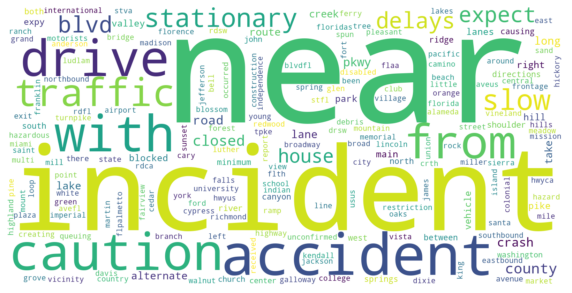

In [ ]:
# Mild Accident
wc = WordCloud(width = 1600, # Estos dos campos son importantes para definir la calidad de la imagen final
               height = 800,
               background_color = 'white', # El color de fondo que buscamos
               ).generate_from_frequencies(dict(words_mild.to_dict('split')['data']))

fig, ax = plt.subplots(figsize = (10,6))
ax.imshow(wc, interpolation = 'bilinear')
ax.axis("off")
plt.show()               

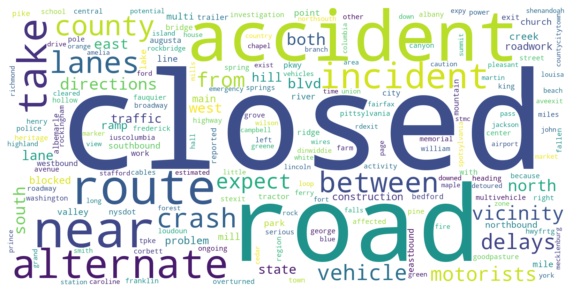

In [ ]:
# Severe Accident
wc = WordCloud(width = 1600, # Estos dos campos son importantes para definir la calidad de la imagen final
               height = 800,
               background_color = 'white', # El color de fondo que buscamos
               ).generate_from_frequencies(dict(words_severe.to_dict('split')['data']))

fig, ax = plt.subplots(figsize = (10,6))
ax.imshow(wc, interpolation = 'bilinear')
ax.axis("off")
plt.show()   

Vemos que hay palabras que figuran en ambos casos, pero con distintos pesos. Esto nos permite armar una probabilidad de que dada una palabra en la descripción, el accidente sea severo o no.

Para simplificar calculos si aparecen varias palabras en una descripción, vamos a asignar un número entre -1 y 1, siendo 1 que el accidente es severo y -1 que no. Si nunguna de las palabras aparece en la descripción asignamos 0. Si más de una palabra aparece, nos quedamos con la que tenga módulo máximo. Esto nos da una especie de función correlación entre la descripción y el target.

In [ ]:
word_corr = pd.merge(words_mild, words_severe, how='outer', on=['Word'], suffixes=('_mild','_severe'))
word_corr.fillna(0.0, inplace=True)

word_corr['corr'] = (word_corr['Count_severe'] - word_corr['Count_mild']) / word_corr[['Count_mild', 'Count_severe']].max(axis=1) 
word_corr

,Word,Count_mild,Count_severe,corr
0,near,13593.0,5013.0,-0.631207
1,incident,13340.0,4232.0,-0.682759
2,accident,12998.0,10557.0,-0.187798
3,caution,10536.0,34.0,-0.996773
4,drive,10104.0,46.0,-0.995447
...,...,...,...,...
409,larch,0.0,23.0,1.000000
410,wight,0.0,23.0,1.000000
411,lyons,0.0,23.0,1.000000
412,hope,0.0,23.0,1.000000


Generamos una función que mapee las descripciones en correlaciones.

In [ ]:
def description_correlation(x, dataframe=word_corr):
  """
  Recibe un string y retorna un list(float64)
  con la correlación de cada palabra según dataframe['corr']
  """
  # Le damos formato a la descripción
  formated_x = re.sub('[^A-Za-z ]+','', x)
   
  # Generamos una lista con las palabras
  lis = formated_x.split()

  result = [dataframe.loc[dataframe['Word'] == word.lower(),'corr'].values[0] if any(dataframe['Word'] == word.lower()) else 0 for word in lis]
  
  return result if len(result) != 0 else [0]

# Creo una nueva columna, transformando las descripciones
df_train['Description_Corr'] = df_train['Description'].apply(description_correlation)

# Me quedo con la correlación de máximo módulo
# Como cortamos en 400 palabras, va a haber palabras de corr 1 o -1
# que en realidad aparecen en unos pocos ejemplos de la clase contraria
# si tenemos listas con 1 y -1 les asignamos correlacion 0.
def max_correlation(lis):
  if (1 in lis) & (-1 in lis):
    return 0
  else:
    return max(lis, key=abs)

df_train['Description_Corr_Mean'] = df_train['Description_Corr'].apply(np.mean)
df_train['Description_Corr'] = df_train['Description_Corr'].apply(max_correlation)

,Severity,Description_Corr,Description_Corr_Mean
Severity,1.00000,0.844250,0.846820
Description_Corr,0.84425,1.000000,0.889105
Description_Corr_Mean,0.84682,0.889105,1.000000


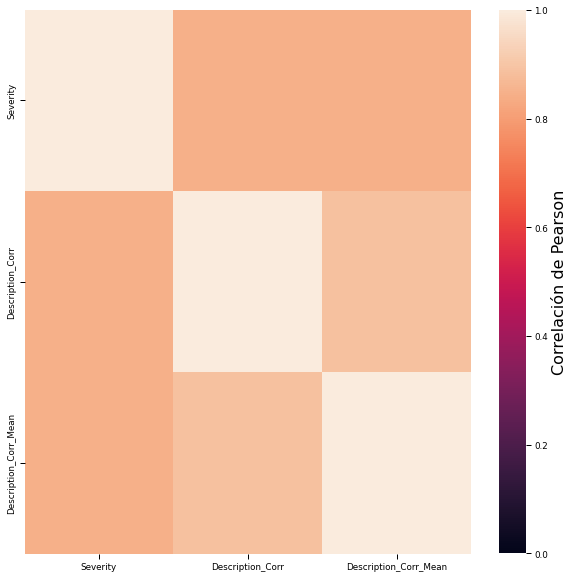

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
sns.heatmap(df_train[['Severity','Description_Corr', 'Description_Corr_Mean']].corr(), vmin=0,
            cbar_kws={'label': 'Correlación de Pearson'})

df_train[['Severity','Description_Corr', 'Description_Corr_Mean']].corr()

Para finalizar tiramos la columna con descripciones. Finalizamos con 16 columnas y 45834 ejemplos.

In [ ]:
df_train.drop(['Description'], axis=1, inplace=True)


In [ ]:
# Transformamos en el conjunto de testeo
df_test['Description_Corr'] = df_test['Description'].apply(description_correlation)
df_test['Description_Corr_Mean'] = df_test['Description_Corr'].apply(np.mean)
df_test['Description_Corr'] = df_test['Description_Corr'].apply(max_correlation)

df_test.drop(['Description'], axis=1, inplace=True)

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45834 entries, 0 to 45833
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Severity               45834 non-null  int64  
 1   Start_Lat              45834 non-null  float64
 2   Start_Lng              45834 non-null  float64
 3   Distance(mi)           45834 non-null  float64
 4   Temperature(F)         45834 non-null  float64
 5   Humidity(%)            45834 non-null  float64
 6   Pressure(in)           45834 non-null  float64
 7   Visibility(mi)         45834 non-null  float64
 8   Wind_Speed(mph)        45834 non-null  float64
 9   Precipitation(in)      45834 non-null  float64
 10  Weather_Delay(min)     45834 non-null  float64
 11  Delta_Time(min)        45834 non-null  float64
 12  Astro_Day              45834 non-null  uint8  
 13  Astro_Night            45834 non-null  uint8  
 14  Description_Corr       45834 non-null  float64
 15  De

## Clasificación de Modelos

Con el dataset final, vamos a clasificar varios modelos y quedarnos con el de mejor desempeño.

In [ ]:
list(df_train.columns)[1:]

['Start_Lat',
 'Start_Lng',
 'Distance(mi)',
 'Temperature(F)',
 'Humidity(%)',
 'Pressure(in)',
 'Visibility(mi)',
 'Wind_Speed(mph)',
 'Precipitation(in)',
 'Weather_Delay(min)',
 'Delta_Time(min)',
 'Astro_Day',
 'Astro_Night',
 'Description_Corr',
 'Description_Corr_Mean']

### RandomForest

In [ ]:
y = np.array(df_train['Severity']) # armo el vector de etiquetas

# extraigo la matriz de features X
features = list(df_train.columns)[1:]
X = df_train[features].to_numpy()

# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# pruebo con un random forest así como viene de fábrica
clf = RandomForestClassifier(class_weight='balanced', random_state=1)  

# ajusto el modelo
clf.fit(X_train, y_train)

# armo el vector de predicciones.
y_hat_test = clf.predict_proba(X_test)[:, 1]
y_hat_train = clf.predict_proba(X_train)[:, 1]

# evaluo el AUC
roc_test = roc_auc_score(y_test, y_hat_test)
roc_train = roc_auc_score(y_train, y_hat_train)
print(roc_test, roc_train)

clf_cv = RandomForestClassifier(class_weight='balanced')  
cv = StratifiedKFold(n_splits=10, shuffle=True)
s = cross_val_score(clf_cv, X_train, y_train, cv=cv,n_jobs=-1)

print("Rendimiento de RF:\t{:0.3} ± {:0.3}".format(s.mean().round(3), s.std().round(3)))

0.9896041769263727 0.9999977355968193
Rendimiento de RF:	0.965 ± 0.004


In [ ]:
clf.score(X_test, y_test)
feature_importance = clf.feature_importances_ 

print('Features: {}'.format(features))
print('Importancia = {}'.format(feature_importance))

Features: ['Start_Lat', 'Start_Lng', 'Distance(mi)', 'Temperature(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Speed(mph)', 'Precipitation(in)', 'Weather_Delay(min)', 'Delta_Time(min)', 'Astro_Day', 'Astro_Night', 'Description_Corr', 'Description_Corr_Mean']
Importancia = [0.05007102 0.0386483  0.03481083 0.01385241 0.01091106 0.01687222
 0.00330145 0.00805284 0.00162598 0.01189439 0.07689615 0.00161262
 0.00132764 0.32141289 0.40871021]


Vemos que los features más importantes salen de la descripción!

Ajusto los hyperparámetros para RandomForest

In [ ]:
param_trees = {'n_estimators': [100, 120, 150, 170], 
               'max_features': ["auto", 1, 5, 10, 15], 
               'max_depth': [5, 20, 50, None], 
               'min_samples_leaf':[1, 2, 5, 10]}
      
cv = StratifiedKFold(n_splits=5, shuffle=True)
clf = RandomForestClassifier(class_weight='balanced')  
gs_rf = GridSearchCV(clf, param_grid=param_trees, cv=cv, verbose=1, n_jobs=3)
gs_rf.fit(X_train, y_train)

# Printeamos el mejor estimador y los resultados
print(gs_rf.best_estimator_)

# armo el vector de predicciones.
y_hat_test = gs_rf.predict_proba(X_test)[:, 1]
y_hat_train = gs_rf.predict_proba(X_train)[:, 1]

# evaluo el AUC
roc_test = roc_auc_score(y_test, y_hat_test)
roc_train = roc_auc_score(y_train, y_hat_train)
roc_test, roc_train

In [ ]:
"""Este es el modelo que uso finalmente"""

# Entreno con los hyperparametros tuneados
clf = RandomForestClassifier(class_weight='balanced', max_depth=20, max_features=10,
                       min_samples_leaf=2, n_estimators=150)  

# Ajustamos el modelo
clf.fit(X_train, y_train)

# Vector de predicciones.
y_hat_test = clf.predict_proba(X_test)[:, 1]
y_hat_train = clf.predict_proba(X_train)[:, 1]

# Evaluamos el AUC
roc_test = roc_auc_score(y_test, y_hat_test)
roc_train = roc_auc_score(y_train, y_hat_train)
print(roc_test, roc_train)

cv_rf = RandomForestClassifier(class_weight='balanced', max_depth=20, max_features=10,
                       min_samples_leaf=2, n_estimators=150)  
cv = StratifiedKFold(n_splits=10, shuffle=True)
s = cross_val_score(cv_rf, X_train, y_train, cv=cv, n_jobs=-1)

print("Rendimiento de RF:\t{:0.3} ± {:0.3}".format(s.mean().round(3), s.std().round(3)))

0.9905516873468055 0.9996896989637715
Rendimiento de RF:	0.967 ± 0.004


In [ ]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler

# Para knn necesitamos estandarizar los features
stds = StandardScaler()
X_train_knn = stds.fit_transform(X_train)
X_test_knn = stds.transform(X_test)

# Armamos el modelo y usamos gridsearch para ajustar el k
model_knn = KNeighborsClassifier()
params = {"n_neighbors":list(range(2,10))}

knn = GridSearchCV(model_knn, params, verbose= True)
knn.fit(X_train_knn, y_train)

# Printeamos el mejor estimador y los resultados
print(knn.best_estimator_)

# Armo el vector de predicciones.
y_hat_test = knn.predict_proba(X_test_knn)[:, 1]
y_hat_train = knn.predict_proba(X_train_knn)[:, 1]

# Evaluo el AUC
roc_test = roc_auc_score(y_test, y_hat_test)
roc_train = roc_auc_score(y_train, y_hat_train)
roc_test, roc_train

Fitting 5 folds for each of 8 candidates, totalling 40 fits
KNeighborsClassifier(n_neighbors=7)


(0.9690930727094391, 0.9916382541652102)

In [ ]:
from sklearn.linear_model import LogisticRegression
LR = LogisticRegression()
parameters = {
            'C':[0.0001,0.001,0.1,1,10,100],
            'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag']
            }

#parameters = {'penalty':['l1','l2'], 'C':[0.001,0.1,1,10,100], 'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag'] }
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

CV_LR = GridSearchCV(LR, parameters, n_jobs= 1)
CV_LR.fit(X_train_knn, y_train)   

# Printeamos el mejor estimador y los resultados
print(CV_LR.best_estimator_)

# Armo el vector de predicciones.
y_hat_test = CV_LR.predict_proba(X_test_knn)[:, 1]
y_hat_train = CV_LR.predict_proba(X_train_knn)[:, 1]

# Evaluo el AUC
roc_test = roc_auc_score(y_test, y_hat_test)
roc_train = roc_auc_score(y_train, y_hat_train)
roc_test, roc_train

LogisticRegression(C=1, solver='liblinear')


(0.9788952889028641, 0.9809391807223523)

In [ ]:
from sklearn import svm

sv = svm.SVC(probability=True)

parameters=  {'kernel': ['linear','rbf'], 'C': [1, 10, 30]}
CV_SVM = GridSearchCV(sv, parameters, n_jobs= 1)
CV_SVM.fit(X_train_knn, y_train)

# Printeamos el mejor estimador y los resultados
print(CV_LR.best_estimator_)

# armo el vector de predicciones.
y_hat_test = CV_SVM.predict_proba(X_test_knn)[:, 1]
y_hat_train = CV_SVM.predict_proba(X_train_knn)[:, 1]

# evaluo el AUC
roc_test = roc_auc_score(y_test, y_hat_test)
roc_train = roc_auc_score(y_train, y_hat_train)
roc_test, roc_train

### CatBosst - https://catboost.ai/en/docs/concepts/python-reference_catboostclassifier

Comparemos con este modelo que usa gradient boosting.

In [ ]:
# Pruebo este modelo que no vumos en clase
!pip install catboost
from catboost import CatBoostClassifier
model_cat = CatBoostClassifier( verbose=False)  

# ajusto el modelo
model_cat.fit(X_train, y_train)

# armo el vector de predicciones.
y_hat_test = model_cat.predict_proba(X_test)[:, 1]
y_hat_train = model_cat.predict_proba(X_train)[:, 1]

# evaluo el AUC
roc_test = roc_auc_score(y_test, y_hat_test)
roc_train = roc_auc_score(y_train, y_hat_train)
print(roc_test, roc_train)

model_cat = CatBoostClassifier(random_state=1, verbose=False) 

cv = StratifiedKFold(n_splits=10, random_state=41, shuffle=True)
s = cross_val_score(model_cat, X_train, y_train, cv=cv, n_jobs=-1)

print("Rendimiento de CB:\t{:0.3} ± {:0.3}".format(s.mean().round(3), s.std().round(3)))

     |████████████████████████████████| 76.6 MB 83 kB/s 
0.9911590288262365 0.9979970001048866
Rendimiento de CB:	0.968 ± 0.004


In [ ]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
parameters = {'depth'         : [4,5,6,7,8,9, 10],
              'learning_rate' : [0.01,0.02,0.03,0.04],
              'iterations'    : [10,30,50,60,70,80,100]
              }
      
cv = StratifiedKFold(n_splits=5, shuffle=True)
model_cat = CatBoostClassifier( verbose=False) 
gs_cb = GridSearchCV(model_cat, param_grid=parameters, cv=cv, verbose=1, n_jobs=3)
gs_cb.fit(X_train, y_train)

# Printeamos el mejor estimador y los resultados
print(gs_cb.best_estimator_)

# armo el vector de predicciones.
y_hat_test = gs_cb.predict_proba(X_test)[:, 1]
y_hat_train = gs_cb.predict_proba(X_train)[:, 1]

# evaluo el AUC
roc_test = roc_auc_score(y_test, y_hat_test)
roc_train = roc_auc_score(y_train, y_hat_train)
roc_test, roc_train

Fitting 5 folds for each of 196 candidates, totalling 980 fits


(0.9887375833428345, 0.9902963166060565)

El modelo sin tunear da mejor que el tuneado, y apenas por arriba que el random Forest. Me voy a quedar con este último porque me parece más transparente a la hora de tunear y porque lo vimos en clase.

## Aplicación a los datos de testeo

Nos quedamos con el Random Forest tuneado, que es es el que mejor performance entregó para los datos de entrenamiento, luego de ajustar los hiperparametros. Vamos a predecir las etiquetas de los datos del archivo "test4alumnxs.csv".

In [ ]:
df_test.head()

,Severity,Start_Lat,Start_Lng,Distance(mi),Temperature(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Speed(mph),Precipitation(in),Weather_Delay(min),Delta_Time(min),Astro_Day,Astro_Night,Description_Corr,Description_Corr_Mean
0,0,35.063640,-85.254840,0.054,42.0,65.0,29.35,10.0,15.0,0.00,10.55,78.383333,1,0,-0.996773,-0.429480
1,0,39.576016,-76.384245,0.125,38.0,96.0,29.84,4.0,6.0,0.06,18.00,238.000000,1,0,-1.000000,-0.210598
2,0,30.492118,-91.143677,0.068,66.0,87.0,30.09,10.0,3.0,0.00,15.00,94.650000,1,0,-0.996773,-0.429480
3,0,44.602770,-123.220610,0.000,50.0,89.0,29.73,10.0,3.0,0.00,12.35,240.000000,1,0,-0.813008,-0.200161
4,0,25.926966,-80.188204,0.161,86.0,57.0,30.03,10.0,10.0,0.00,17.00,122.083333,1,0,-1.000000,-0.260988


In [ ]:
# Estas dos lineas son para el test que me pasó Enzo
y_held = df_test['Severity']
features = list(df_test.columns)[1:]

# Armo la matriz de features para el conjunto de testeo
X_held = df_test[features].to_numpy()
print(X_held.shape)
# Genero predicciones con el mejor modelo
predicciones = clf.predict_proba(X_held)[:, 1] 

# Printeamos para chequear que el formato este bien
print(predicciones)
print(predicciones.shape)

# Guardamos en un csv para entregar
np.savetxt('VillaJulian.csv', predicciones, delimiter=",")

# Printeo lo que me pasó Enzo
roc_test = roc_auc_score(y_held, predicciones)
print(roc_test)

(11372, 15)
[0.00000000e+00 8.51337483e-04 0.00000000e+00 ... 6.31515164e-01
 9.64439125e-01 0.00000000e+00]
(11372,)
0.9913932767128232


Una vez grabado el archivo, es fácil de descargar, buscándolo en el ícono de carpeta a la izquierda y apretando 'Descargar' en el menú desplegable, como muestra la imagen:

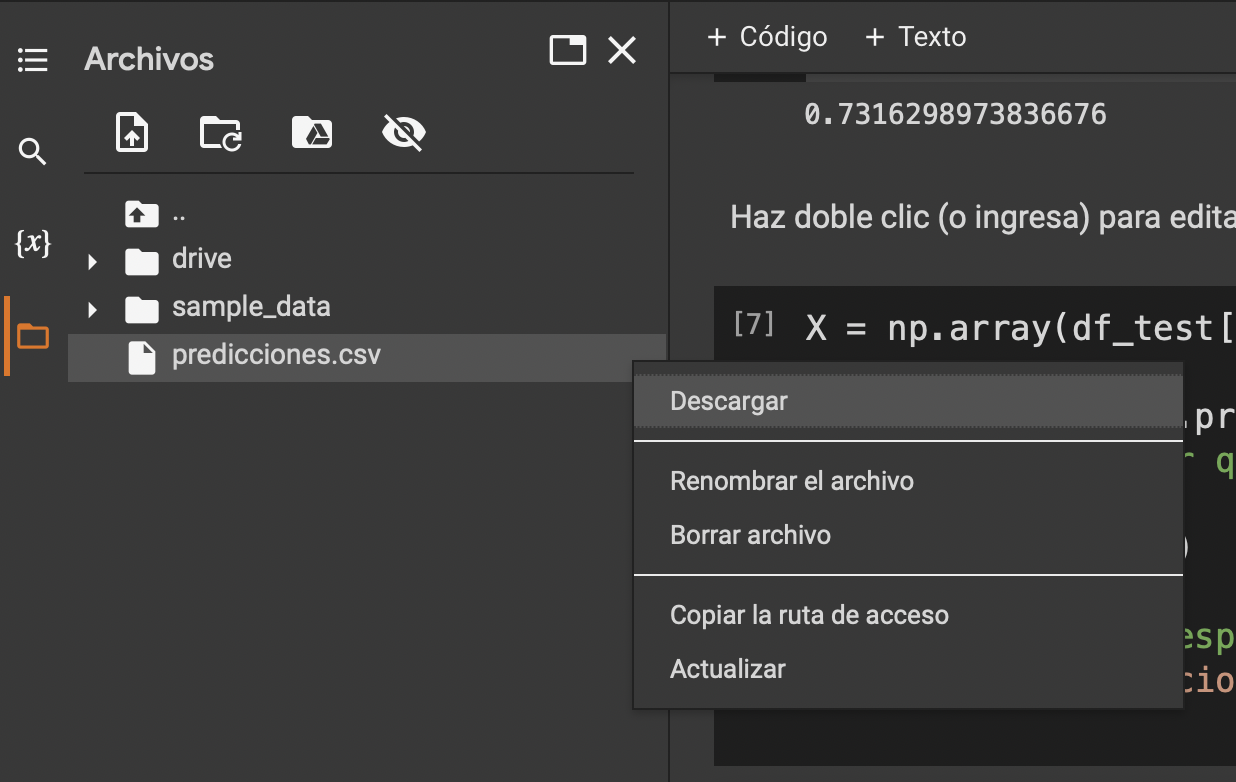